# SYDE 556/750: Simulating Neurobiological Systems

Accompanying readings: Chapters 4, 5

## Temporal Representation

- In the previous lectures, we covered representation of a vector space by a population of neurons
    - We converted a vector $x$ into neural activity values $a_i$, and then converted those back to the original value $\hat{x}$.  
- What happens if $x$ changes over time?  
    - I.e. if we have $x(t)$, how do we get $a_i(t)$?
    - Seems pretty easy:
        - $a=G[\alpha e \cdot x + J^{bias}]$, so...
        - $a(t)=G[\alpha e \cdot x(t) + J^{bias}]$
        - where $G[J(t)]= {1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J(t)})}}$

In [1]:
%pylab inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


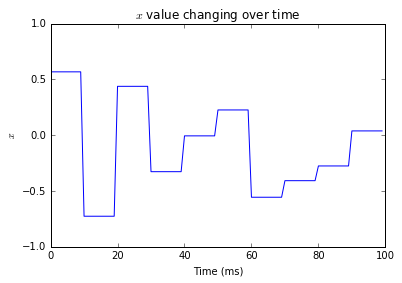

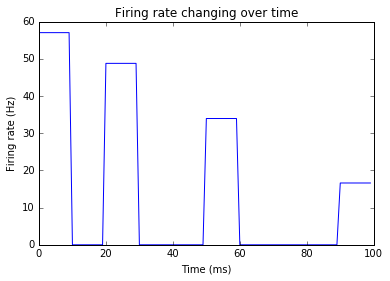

In [2]:
import nengo
import numpy

n = nengo.neurons.LIFRate()

x = numpy.zeros(100)
for i in range(10):
    x[i*10:(i+1)*10]=numpy.random.uniform(-1,1)

figure()
title('$x$ value changing over time')
plot(x)
ylabel('$x$')
ylim(-1,1)
xlabel('Time (ms)')

figure()
title('Firing rate changing over time')
plot(n.rates(x, gain=1.5, bias=1))
ylabel('Firing rate (Hz)')
xlabel('Time (ms)')
show()

- Unfortunately, that formula for $G[J(t)]$ is an *average* firing rate over a long period of time.
    - What does it mean to be firing at 10Hz for 10ms?
- We need to model what's actually happening to that neuron over time 

## Leaky Integrate-and-Fire neurons

- Pretty much the standard computationally efficient neuron model
    - Simple
    - Produces spikes
    - Limiting case of other more complex neuron models
    - All parameters map onto known properties of real neurons
    


<img src="files/lecture3/neuron.png">

- Bilipid cell membrane acts as a capacitor

- Flow of ions through the cell membrane ion channels is a resistor
    - This is the "leak" current
- Resistance and capacitance together give $\tau_{RC}$
    - $\tau_{RC}=R C$
- When voltage passes some threshold, neuron emits a "spike"
    - Very fast, sharp response that's pretty much the same each time
    - Spike at time $t_n$ modelled as $\delta(t-t_n)$


- Neuron recovers over a short period of time
    - Refractory time $\tau_{ref}$
    - During this time the voltage is reset to some resting level

<img src="files/lecture3/lif.png">



- As an RC circuit with a nonlinearity:

<img src="files/lecture3/lif_circuit.png">

- Typical values
    - $\tau_{RC}$: 0.02 seconds
    - $\tau_{ref}$: 0.002 seconds
    - Reset voltage (a.k.a. resting potential): -70mV
    - Firing threshold (a.k.a. threshold potential): -55mV
        - NOTE: we normalize this so that reset is at 0 and firing is at 1
        - This does not affect anything about the behaviour of the model
        
- For lots more info, see Unit 2 in [this online course](http://www.saylor.org/courses/bio303/)

### The LIF RC circuit

- Let's ignore the spiking elements for now, so here's the circuit

<img src="files/lecture3/rc_circuit.png">

### Useful physical laws
- Kirchhoff's Current Law
    - Currents at a point have to add up to zeros
    - Current coming into the neuron has two paths
    - $J_{M} = J_R+J_C$
    
- Ohm's Law
    - Formula for current through a resistor
    - $ J_R = {V \over R}$
    
- Capacitor
    - $ C = {Q \over V}$
    - $ Q = C V $
    - Change in these quantities over time gives
        - $ {{dQ} \over {dt}} = C {{dV} \over {dt}} $
    - Rate of change of charge is current
        - $ J_C = C {{dV} \over {dt}} $


 
- Applying these laws to RC circuits:
    - $ J_{M} =  {V \over R} + C {{dV} \over {dt}} $
    - Then solve for change in voltage with input

$$
\begin{align}
{{dV} \over {dt}} &= {1 \over C}(J_{M} - {V \over R})  \\
 &= {1 \over {RC}}[R J_{M} - {V}]  \\
 &= {1 \over {\tau_{RC}}} [R J_{M} - {V}] 
\end{align}
$$

### LIF RC Circuit Behaviour
- If we solve the general ODE, we get a convolution:

$
\begin{align}
V(t) = \frac{R}{\tau_{RC}} \int_0^t e^{-(t-t')/\tau_{RC}} J_M(t')\; dt'
\end{align}
$

- I.e. the voltage right now (at $t$) depends on all past current input, $J_M(t')$, where each input is weighted by a function that exponentially decays as it gets further away (in the past) from the current time (a kind of memory).



- If $J_M$ is constant:

$
\begin{align}
V(t) &= \frac{R J_M}{\tau^{RC}} e^{-t/\tau_{RC}}\int_0^t e^{t'/\tau_{RC}} \; dt' \\
&= J_M R (1-e^{-t/\tau_{RC}}) \end{align}
$

- How long does it take to get to threshold?
- How long between spikes?
- Firing rate? 


- How long does it take to get to threshold?
    - $ V_{th} = J_MR(1-e^{-t_{th}/\tau_{RC}}) $
    - $ t_{th} = -\tau_{RC} ln (1-{V_{th} \over {J_MR}}) $

- How long between spikes?
    - $t_{th} + \tau_{ref}$
    
- Firing rate
    - $a = {1 \over {t_{th} + \tau_{ref}}}$    
    - $a = {1 \over {\tau_{ref}-\tau_{RC}ln(1-{V_{th} \over {J_MR}})}} $

- Simplify by assuming $V_{th}=1$ and $R=1$
    - $a = {1 \over {\tau_{ref}-\tau_{RC}ln(1-{1 \over J_M})}} $    
    - This is the rate approximation of the neuron
    
- But we can't assume a constant $J_M$ in a real brain!
- It will definitely change over time (since $x(t)$ also changes over time)
- So we need to do a computer simulation of the differential equation explicitly
    - $ {{dV} \over {dt}} = {1 \over {\tau_{RC}}} [R J_{input}(t) - {V(t)}]  $
    

## Spikes
- When simulating the LIF neuron, we need to monitor threshold, as that when the 'spike' occurs
- A LIF neuron treats all spikes the same, and just 'pastes' them in 
    - As opposed to simulating the nonlinear differential equations that describe the actual voltage changes

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


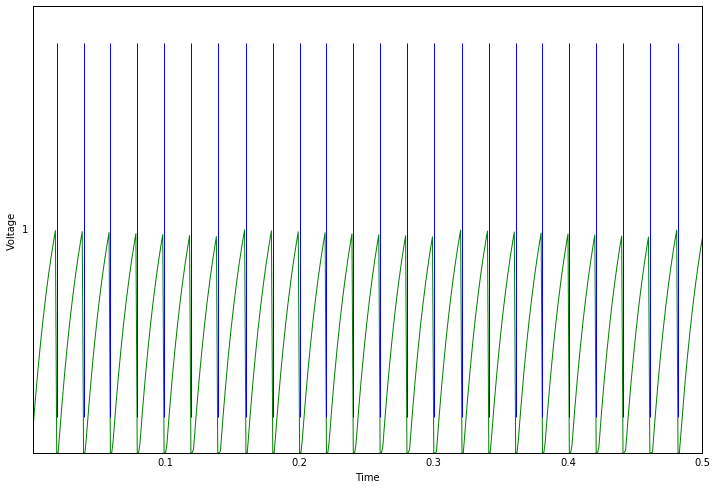

In [59]:
import nengo
from nengo.utils.matplotlib import rasterplot

model = nengo.Network(label='Spiking Neurons')

with model:
    stimulus = nengo.Node(0)
    ens = nengo.Ensemble(1, dimensions=1, 
                         encoders = [[1]],
                         intercepts = [-.5],
                         max_rates= [100])
    
    nengo.Connection(stimulus, ens)
    
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
    voltage_p = nengo.Probe(ens.neurons, 'voltage')
    stim_p = nengo.Probe(stimulus)
    
sim = nengo.Simulator(model)
sim.run(.5)

t = sim.trange()
figure(figsize=(12, 8))
ax = gca()
ax.plot(t, sim.data[voltage_p],'g')
rasterplot(t, sim.data[spikes_p], ax=ax)
ylim((0,2))
ylabel("Voltage")
xlabel("Time");

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


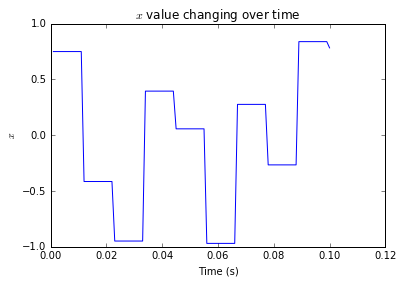

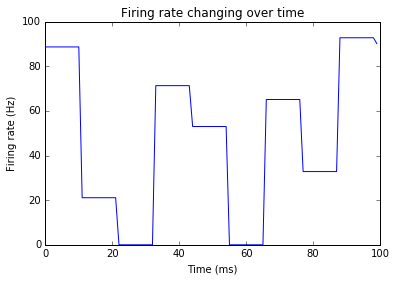

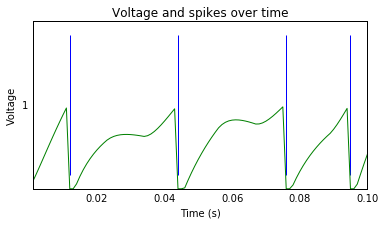

In [60]:
import numpy as np
from nengo.utils.functions import piecewise

x = dict(zip(np.linspace(0,.1,10), np.random.uniform(-1,1,10)))

with model:
    stimulus.output = piecewise(x)
        
sim = nengo.Simulator(model)
sim.run(.1)

t = sim.trange()

figure()
title('$x$ value changing over time')
plot(t, sim.data[stim_p])
ylabel('$x$')
ylim(-1,1)
xlabel('Time (s)')

figure()
title('Firing rate changing over time')
plot(ens.neuron_type.rates(sim.data[stim_p], gain=sim.data[ens].gain, bias=sim.data[ens].bias))
ylabel('Firing rate (Hz)')
xlabel('Time (ms)')

figure(figsize=(6, 3))
ax = gca()
rasterplot(t, sim.data[spikes_p], ax=ax)
ax.plot(t, sim.data[voltage_p],'g')#, drawstyle='steps-post') #if want to see exact timing
ylim((0,2))
title('Voltage and spikes over time')
ylabel("Voltage")
xlabel("Time (s)");

- Let's try a sine wave input

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


(-1, 2)

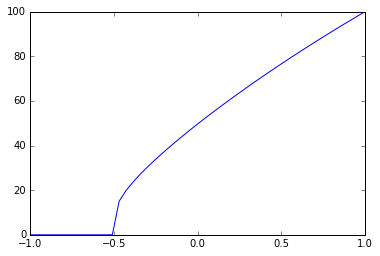

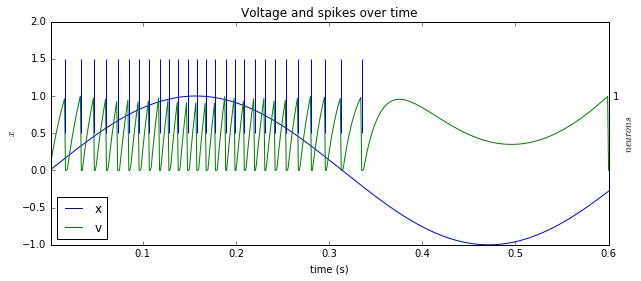

In [61]:
#have to run previous cells

with model:
    stimulus.output = lambda t: np.sin(10*t)
    
sim = nengo.Simulator(model)
sim.run(.6)

nengo.utils.matplotlib.plot_tuning_curves(ens, sim)

t = sim.trange()     
figure(figsize=(10,4))
plot(t, sim.data[stim_p], label='x')
ax = gca()
ax.plot(t, sim.data[voltage_p],'g', label='v')
ylim((-1,2))
ylabel('$x$')
xlabel('time (s)')
legend(loc='lower left');

rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), use_eventplot=True)
title('Voltage and spikes over time')
ylabel("Voltage");
xlabel("Time");
ylabel('$neurons$')
ylim((-1,2))

- So this is how we're going to model neurons over time
- Weaknesses of this approach
    - These are "point" neurons (i.e. we're assuming the body of the neuron is just one infinitessimal point, rather than having lots and lots of compartments, each with its own RC circuit)
    - Assumes R is a constant
    - Assumes $V_{th}$ is a constant
    - Assumes no adaptation (it's harder for a neuron to fire after it has recently fired)
    - Doesn't consider nonlinearities at the input
- Each of these could be added
    - Adding these increases computational cost
    - Not going to worry about it now
    - But we should make sure everything we do would also work with more detailed neuron models


    
### The time vs. rate-coding debate

- There is a standard ongoing debate in the neuroscience literature about whether neurons use a "rate" code or a "timing" code
- Rate code
    - The important thing is the firing rate over some window of time (~100ms)
- Time code
    - The *precise* pattern of spike generation carries information
- The NEF gets rid of this distinction
    - Some people call what we do rate coding, some call it temporal coding
- The important thing is how to do the decoding usefully ... in short:
    - 'Slow' decoders will seem like a rate code
    - 'Fast' decoders will seem like a time code

## Temporal Decoding

- So that's what happens when we allow $x(t)$ to vary over time
    - We keep $J(t)=\alpha e \cdot x(t) + J^{bias}$
    - Feed that into the neuron model $G[J(t)]$
    - We get out a sequence of spikes
    
- How do decode this?
    - How do we get an estimate of $x$ given that sequence of spikes?
    
- Can we stick with linear decoding?
    - Let's consider a case with 2 neurons
    - For simplicity, use the same $\alpha$ and $J^{bias}$, but use $e_1=1$ and $e_2=-1$

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


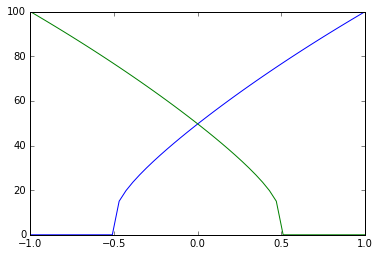

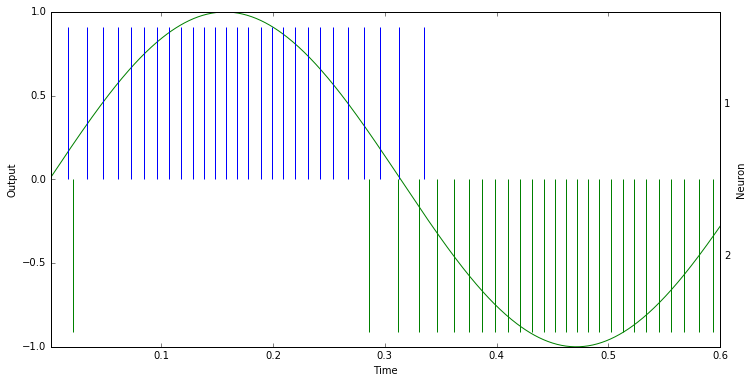

In [62]:
#assumes has done %pylab inline 
import numpy as np
import nengo
from nengo.utils.matplotlib import rasterplot

model = nengo.Network(label='Two Neurons')

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.5, -.5],
                         max_rates= [100, 100])
    nengo.Connection(stim, ens)
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6)

nengo.utils.matplotlib.plot_tuning_curves(ens, sim)

t = sim.trange()
figure(figsize=(12, 6))
plot(t, sim.data[stim_p],'g')
ax = gca()
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), use_eventplot=True)
ylabel("Neuron");

<a id="decoders"></a>
- Can we still decode $x$ using a sum of activities?
    - $\hat{x}(t)=\sum_i{a_i(t) d_i}$
    
- Let's use exactly the same technique we did before to find $d$
    - $ d = \Gamma^{-1} \Upsilon $
    - $ \Upsilon_i = \sum_x a_i x dx$
    - $ \Gamma_{ij} = \sum_x a_i a_j dx $

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


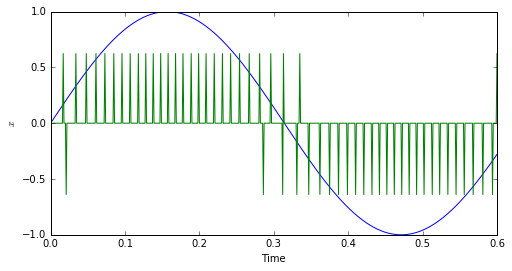

In [63]:
import numpy as np
import nengo

model = nengo.Network(label='Decoding Neurons')

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.5, -.5],
                         max_rates = [100, 100])
    temp = nengo.Ensemble(10, dimensions=1)
    
    nengo.Connection(stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6)

t = sim.trange()

x = sim.data[stim_p][:,0]

A = sim.data[spikes_p]

gamma=np.dot(A.T,A)
upsilon=np.dot(A.T,x)
d = np.dot(np.linalg.pinv(gamma),upsilon)

xhat = np.dot(A, d)

figure(figsize=(8,4))
plot(t, x, label='x')
plot(t, xhat)
ylabel('$x$')
#ylim(-1,1)
xlabel('Time');

- What if we add more neurons?

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


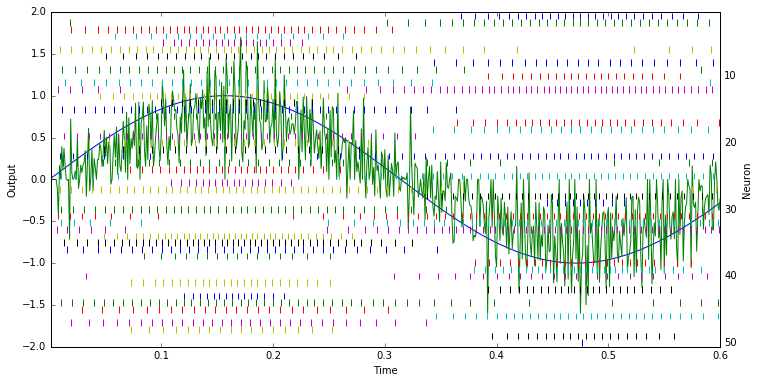

In [65]:
import numpy as np
import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform

model = nengo.Network(label='Decoding Neurons')

N = 50 

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(N, dimensions=1,
                         max_rates=Uniform(100,200))
    temp = nengo.Ensemble(10, dimensions=1)
    
    nengo.Connection(stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6)

x = sim.data[stim_p][:,0]

A = sim.data[spikes_p]

gamma=np.dot(A.T,A)
upsilon=np.dot(A.T,x)
d = np.dot(np.linalg.pinv(gamma),upsilon)

xhat = np.dot(A, d)

t = sim.trange()
figure(figsize=(12, 6))
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, xhat,'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), use_eventplot=True, color='k')
ylabel("Neuron");

- What's happening here?
- At a given instant in time $t$, only a very small number of neurons are firing
    - If no neurons are firing at that instant, $\hat{x}=0$
    - There are usually only one or two neurons firing at any given time
    - As $dt$ gets smaller, the problem gets even worse
- What can we do?    

## Temporal filtering

- We want a spike to contribute to other points in time
- So we want to convert a train of spikes into some continuous function
- Convolution:
    -  $\hat{x}(t)=\sum_i{a_i(t) * h(t) d_i}$
    
- What should we use for $h(t)$?
    - Maybe a gaussian?
    - $h(t) = e^{-t^2 / {2\sigma^2}}$

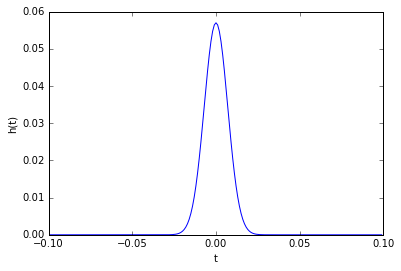

In [66]:
import numpy as np

dt = 0.001
sigma = 0.007
t_h = np.arange(200)*dt-0.1
h = np.exp(-t_h**2/(2*sigma**2))
h = h/norm(h,1)

figure()
plot(t_h, h)
xlabel('t')
ylabel('h(t)');

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


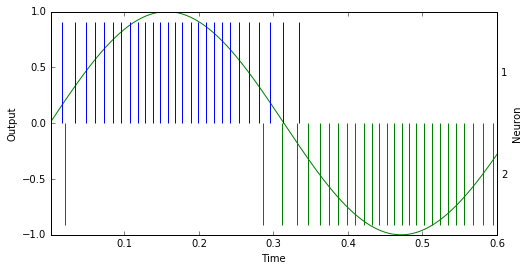

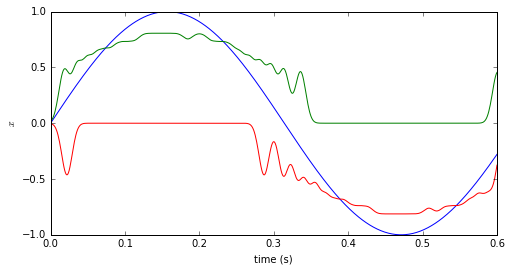

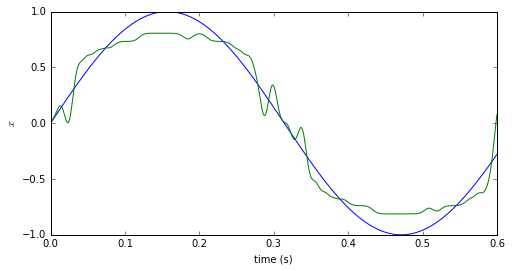

In [67]:
import nengo
from nengo.utils.matplotlib import rasterplot

model = nengo.Network(label='Decoding Neurons')

with model:
    stim = nengo.Node(lambda t: np.sin(10*t))
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.5, -.5],
                         max_rates = [100, 100])
    temp = nengo.Ensemble(10, dimensions=1)
    
    nengo.Connection(stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(.6)

t = sim.trange()
x = sim.data[stim_p]
d = sim.data[connection].weights.T

fspikes1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')

A = np.array([fspikes1, fspikes2]).T

xhat = np.dot(A, d)

figure(figsize=(8, 4))
ax = gca()
plot(t, sim.data[stim_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), use_eventplot=True, color='k')
ylabel("Neuron")

figure(figsize=(8,4))
plot(t, x, label='x')
plot(t, fspikes1*d[0])
plot(t, fspikes2*d[1])
ylabel('$x$')
xlabel('time (s)')

figure(figsize=(8,4))
plot(t, x, label='x')
plot(t, xhat, label='x')
ylabel('$x$')
xlabel('time (s)');

- Better, but how can we improve this?
    - Different shapes for $h(t)$?
    - Different $\sigma$?
- Is there a general solution?

## Optimal filters

- Let's try to find the optimal filter for a particular special case
    - Two neurons
    - Same $\alpha$ and $J^{bias}$ but different $e$ (-1 and +1)

$$\hat{x}(t)=\sum_i^N{a_i(t) * h(t) d_i}$$

- Since there are two neurons and they are opposites of each other, we can assume that $d_1=-d_2$ (i.e. they both contribute equally, but oppositely)

    - $\hat{x}(t)= \sum_i{a_i(t) * h(t) d_i} $ 
    - $\hat{x}(t)= a_1(t)*h(t)d_1 + a_2(t)*h(t)d_2$
    - $\hat{x}(t) = (a_1(t)-a_2(t))*h(t) d_1$
    - $\hat{x}(t) = (a_1(t)-a_2(t))*h(t)$ (since we can roll the constant into $h(t)$
    
- Let's call $a_1(t)-a_2(t)=r(t)$, for *response*
- In this case, it's a difference of spike trains

$\hat{x}(t)=r(t) * h(t)$



    


### Random inputs

- Can't just optimize for decoding a sine wave
    - Needs to work for any random input

- What do we mean by a random input?

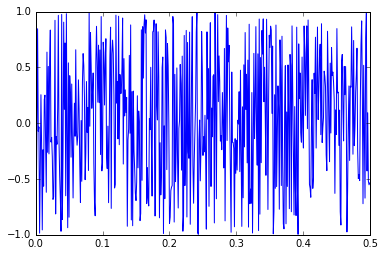

In [11]:
import numpy as np
x = np.random.uniform(-1,1,500)
plot(np.arange(500)*0.001, x);

- Maybe that's a bit too random
- Many signals don't change that quickly
    - How do we get a random signal that doesn't change so quickly?
    - I.e. a signal with a limit on its maximum frequency?

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


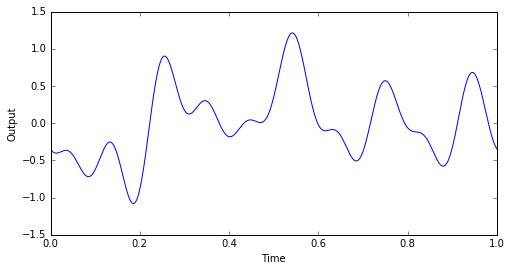

In [69]:
from nengo.processes import WhiteSignal

dt = 0.001
max_freq = 10

model = nengo.Network('White Noise')
with model:
    sig = nengo.Node(output=WhiteSignal(period=1, high=10, rms=0.5))
    
    sig_p = nengo.Probe(sig)

sim = nengo.Simulator(model)
sim.run(1.0)

t = sim.trange()
x = sim.data[sig_p]

figure(figsize=(8, 4))
ax = gca()
plot(t, sim.data[sig_p])
ylabel("Output")
xlabel("Time");

- What is this doing?
- Generate random Fourier coefficients and convert back to time domain
    - Randomly generate coefficients from a Gaussian distribution
    - For $\omega$ values outside of some range, set to zero

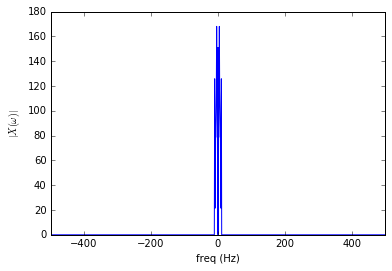

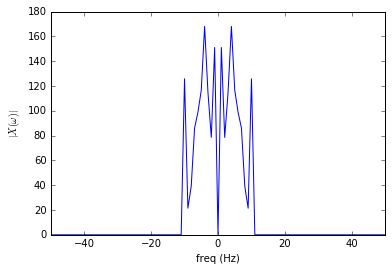

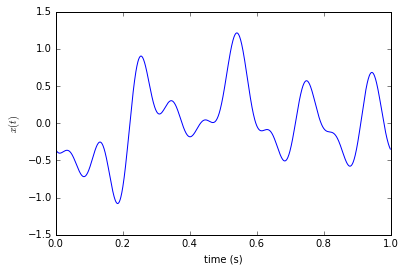

In [74]:
import numpy as np

T=1.0
dt=0.001
signal = sim.data[sig_p][:,0]

sig_freqs = np.fft.fftshift(np.fft.fft(signal))

t = np.arange(int(T/dt))*dt
freq = np.arange(int(T/dt))/T - (T/dt)/2

figure()
plot(freq, np.abs(sig_freqs))
xlim(-500, 500)
xlabel('freq (Hz)')
ylabel('$|X(\omega)|$')

figure()
plot(freq, np.abs(sig_freqs))
xlim(-50, 50)
xlabel('freq (Hz)')
ylabel('$|X(\omega)|$')

figure()
plot(t, signal)
xlabel('time (s)')
ylabel('$x(t)$');

- Things to remember
    - $X(\omega)$ values are *complex numbers*
    - When we plot $X(\omega)$ we actually plot $|X(\omega)|$
    - Since $x(t)$ should be real (i.e. no imaginary component), we expect $X(\omega)$ to be constrained
    - This constraint is that $X(\omega)=X(-\omega)^*$
    - (i.e., the complex conjugate: the real parts are equal, and the imaginary parts switch sign)
    

# Finding an optimal decoder

- $\hat{x}(t)=r(t) * h(t)$
    - $r(t)$ is the response of the two neurons combined together
    - $r(t)=a_1(t)-a_2(t)$
    - $h(t)$ is the filter we are trying to find
- How do we find $h(t)$?
    - Convolution is annoying; let's get rid of it
    - One nice thing about convolution is that it turns into multiplication when you do a Fourier transform
    
$\hat{X}(\omega) = R(\omega)H(\omega)$

- We want to find $H(\omega)$ that minimizes the error
    - $E = (X(\omega)-\hat{X}(\omega))^2$ (added up over all time/frequency)
    - $E = (X(\omega)-R(\omega)H(\omega))^2$ (added up over all time/frequency)
    
- But, we know that our signal $x(t)$ can be written in the frequency domain as a sum of sine waves (that's the Fourier transform)
    - We've already computed those for our signal $X$; that's how we made it in the first place
    - So, we can write our error in terms of different frequency values $\omega$
    
    - $E(\omega) = (X(\omega)-R(\omega)H(\omega))^2$
    
    - Now we can take the derivative and set it equal to zero to do the minimization
    
    - $H(\omega)= {{X(\omega)R^*(\omega)} \over {|R(\omega)|^2}} $
    - Note the complex conjugate that appears there
    
- So now we can find $H(\omega)$ given the Fourier transform of our signal $X(\omega)$ and the Fourier transform of the spiking response $R(\omega)$

### Notes for comparison to the textbook

- Here we're using the convention that lower-case letters are for time-domain functions and upper-case letters are used for Fourier transfomr
    - $x(t) \rightarrow X(\omega)$
    - $r(t) \rightarrow R(\omega)$
    - $h(t) \rightarrow H(\omega)$
- The textbook uses $A(\omega)$ instead of $X(\omega)$
    - $A$ for amplitude
    - This has caused confusion with $A$ as the matrix for activities of neurons, so I've switched it here


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


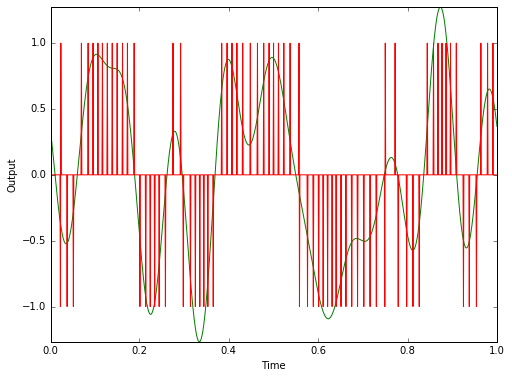

In [115]:
import nengo
from nengo.processes import WhiteSignal

dt = 0.001
max_freq = 10
T = 1.0

model = nengo.Network('White Noise')
with model:
    in_stim = nengo.Node(output=WhiteSignal(T, high=max_freq, rms=0.5))
    ens = nengo.Ensemble(2, dimensions=1,
                         encoders = [[1],[-1]],
                         intercepts = [-.3, -.3],
                         max_rates= [100, 100])
    temp = nengo.Ensemble(1, dimensions=1)

    nengo.Connection(in_stim, ens)
    connection = nengo.Connection(ens, temp) #This is just to generate the decoders
   
    stim_p = nengo.Probe(in_stim)
    spikes_p = nengo.Probe(ens.neurons, 'spikes')
    dec_p = nengo.Probe(ens)
   
sim = nengo.Simulator(model)
sim.run(T)

r_plot = (sim.data[spikes_p][:,0]-sim.data[spikes_p][:,1])*dt
r = sim.data[dec_p][:,0] #properly scaled r
signal = sim.data[stim_p][:,0]

t = sim.trange()
figure(figsize=(8, 6))
plot(t, sim.data[stim_p],'g')
plot(t, r_plot,'r')
ylabel("Output")
xlabel("Time")
axis('tight');

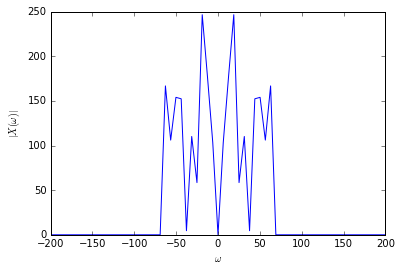

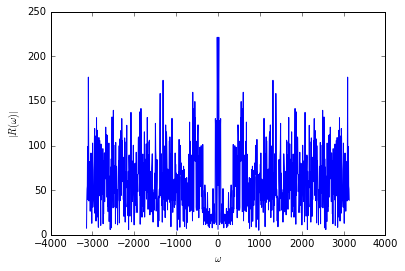

In [116]:
freq = np.arange(int(T/dt)) - (T/dt)/2
omega = freq*2*numpy.pi

X = np.fft.fftshift(np.fft.fft(signal))
R = np.fft.fftshift(np.fft.fft(r))

figure()
plot(omega, np.abs(X))
xlabel('$\omega$')
ylabel('$|X(\omega)|$')
xlim(-200,200)

figure()
plot(omega, np.abs(R))
xlabel('$\omega$')
ylabel('$|R(\omega)|$');

- Now we can find our optimal filter

 $H(\omega)= {{X(\omega)R^*(\omega)} \over {|R(\omega)|^2}} $

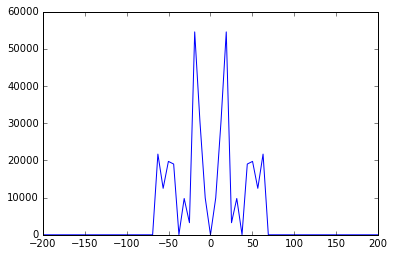

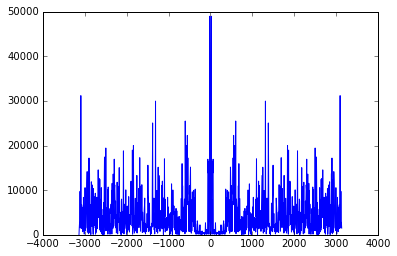

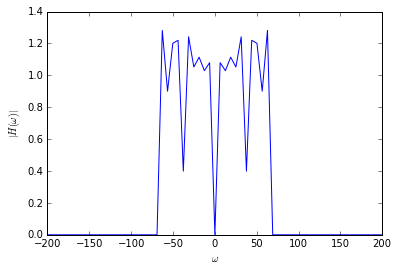

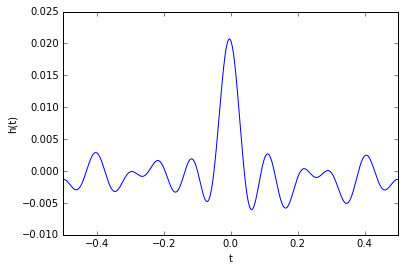

In [117]:
Rmag = R*R.conjugate() #=np.abs(R)**2
#Rmag[(Rmag.shape[0]-1)/2 + 1] = (Rmag.shape[0]-1)/2 #set zero DC term
H = X*R.conjugate() / Rmag
h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real

figure()
plot(omega, np.abs(X*R.conjugate()))
xlim(-200,200)

figure()
plot(omega, np.abs(Rmag))

figure()
plot(omega, np.abs(H))
xlabel('$\omega$')
ylabel('$|H(\omega)|$')
xlim(-200,200)

figure()
plot(freq*dt,h)
xlabel('t')
ylabel('h(t)')
xlim(-.5,.5);

Does this new filter work?

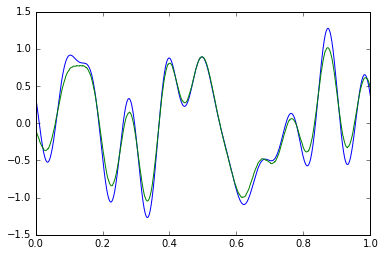

RMSE: 0.013855508547


In [118]:
fspikes1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')

A = np.array([fspikes1, fspikes2]).T
d = sim.data[connection].weights.T

xhat = np.dot(A, d)[:,0]

figure()
plot(t, signal)
plot(t, xhat)
show()
print 'RMSE:', np.average((signal-xhat)**2)

### Testing how well it generalizes

- If it's a good decoder, it should work for other inputs too

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


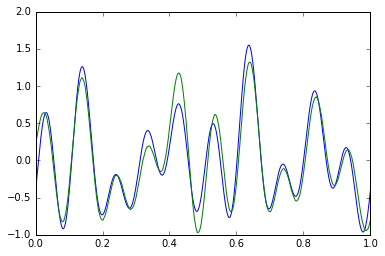

RMSE: 0.031122797469


In [119]:
sim = nengo.Simulator(model)
sim.run(T)
sig = sim.data[stim_p][:,0]

fspikes1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')

A = np.array([fspikes1, fspikes2]).T
d = sim.data[connection].weights.T #not needed

xhat = np.dot(A, d)[:,0]

t = sim.trange()
figure()
plot(t, sig)
plot(t, xhat)
show()
print 'RMSE:', np.average((sig-xhat)**2)

- It's a few times worse on a different signal
- Not bad, but could use some improvement

### Improving the optimal decoder

- We're only training on a pretty small set of data
    - So let's increase $T$
    - This helps, but can get computationally expensive to generate more and more data
- There's also a bit of a shortcut
    - We've already created a pretty long signal ($T=1.0$ seconds)
    - We know the filter should probably decay towards zero
        - A spike shouldn't affect values far away from when it happens
    - So let's take our one existing signal and chop it up into lots of little signals
        

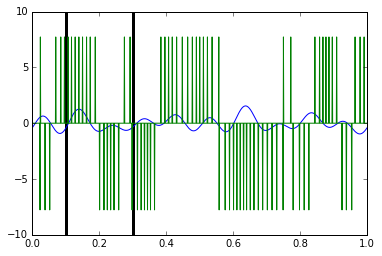

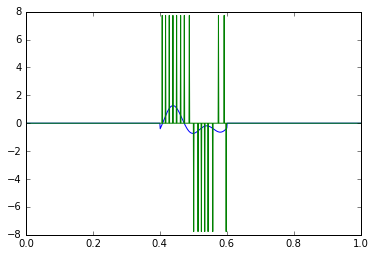

In [120]:
sig2 = np.zeros_like(sig)
r2 = np.zeros_like(r)

sig2[400:600] = sig[100:300]
r2[400:600] = r[100:300]

figure()
plot(t, sig)
plot(t, r)
vlines(0.1, -10, 10, linewidth=3)
vlines(0.3, -10, 10, linewidth=3)

figure()
plot(t, sig2)
plot(t, r2);

- Add up a whole bunch of these with different slices
- But, this introduces some weird edge effects at the beginning and ending of the window
- So we can do some sort of smoothing of the data (as described in Appendix B.3)
    - We use a Gaussian because its Fourier transform is local in frequency (unlike a square)

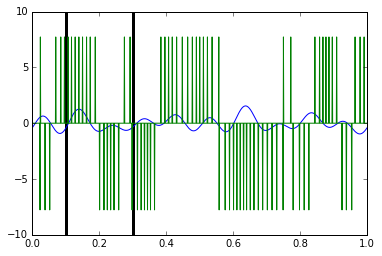

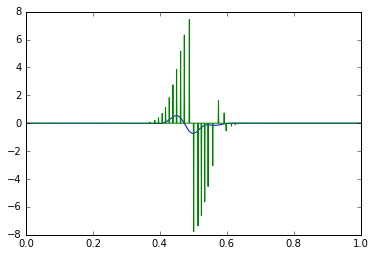

In [121]:
sigma = 0.06 #This should be ~3x longer than the neuron memory
window = np.exp(-(t-0.5)**2/(sigma**2))

sig2w = np.roll(sig, 300)*window
r2w = np.roll(r, 300)*window

figure()
plot(t, sig)
plot(t, r)
vlines(0.1, -10, 10, linewidth=3)
vlines(0.3, -10, 10, linewidth=3)

figure()
plot(t, sig2w)
plot(t, r2w)
show()

- The last graph can be thought of as one trial, which we perform at every $\Delta t$ and then average over
- So we're going to take our original data ($x(t)$ and $r(t)$) and multiply it by another function (the Gaussian) in the time domain
- Consequently, in the frequency domain, this multiplication becomes a...

$$H(\omega)= {{(X(\omega)R^*(\omega)) * W(\omega)} \over {|R(\omega)|^2*W(\omega)}} $$

- So we're windowing and averaging in time because convolution in frequency (it's kind of unusual to see convolution in frequency), which gives an efficient method for estimation.

In [122]:
# original code ignoring DC
H = (X*R.conjugate()) / (R*R.conjugate())

# new code
sigma_t = 0.025
W2 = np.exp(-omega**2*sigma_t**2)
H = (np.convolve(X*R.conjugate(),W2, 'same')) / (np.convolve(R*R.conjugate(),W2, 'same'))

How well does this work?

In [123]:
in_stim.output = WhiteSignal(T, high=10, rms=0.5)

sim = nengo.Simulator(model)
sim.run(T)
sig1 = sim.data[stim_p][:,0]

r = sim.data[dec_p][:,0] #properly scaled r

X = np.fft.fftshift(np.fft.fft(sig1))
R = np.fft.fftshift(np.fft.fft(r))

sigma_t = 0.06
W2 = np.exp(-omega**2*sigma_t**2)
Rmag = R*R.conjugate()
Rmag[(Rmag.shape[0]-1)/2 + 1] = .1 #remove zero DC term
H = (np.convolve(X*R.conjugate(),W2, 'same')) / (np.convolve(Rmag,W2, 'same'))
h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


- What does this new filter look like?
- How does it compare without windowing?

(-0.2, 0.2)

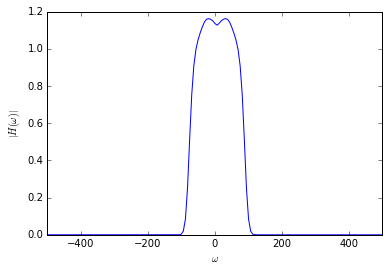

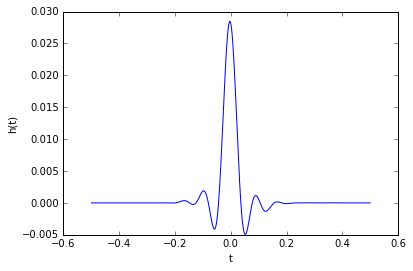

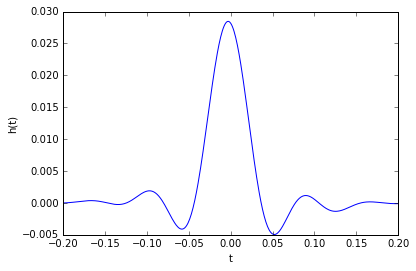

In [124]:
figure()
plot(omega, np.abs(H))
xlabel('$\omega$')
ylabel('$|H(\omega)|$')
xlim(-500, 500)

figure()
plot(t-T/2, h)
xlabel('t')
ylabel('h(t)')

figure()
plot(t-T/2, h)
xlabel('t')
ylabel('h(t)')
xlim(-0.2, 0.2)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


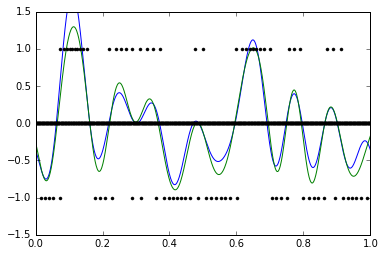

RMSE: 0.0191466292772
RMSE: 0.0181515925027


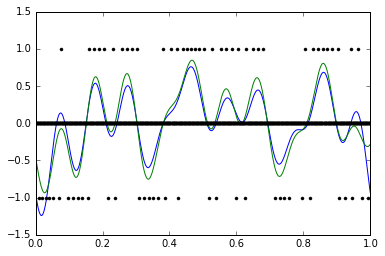

In [125]:
spikes1 = sim.data[spikes_p][:,0]
fspikes1_1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2_1 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')
spikes_1 = (sim.data[spikes_p][:,0]-sim.data[spikes_p][:,1])*sim.dt

sim = nengo.Simulator(model)
sim.run(T)
sig2 = sim.data[stim_p][:,0]

fspikes1_2 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2_2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')
spikes_2 = (sim.data[spikes_p][:,0]-sim.data[spikes_p][:,1])*sim.dt

A1 = numpy.array([fspikes1_1, fspikes2_1]).T
A2 = numpy.array([fspikes1_2, fspikes2_2]).T

d = sim.data[connection].weights.T

x1hat = np.dot(A1, d)[:,0]
x2hat = np.dot(A2, d)[:,0]

t = sim.trange()
figure()
plot(t, sig1)
plot(t, x1hat)
plot(t, spikes_1, 'k.')
ylim(-1.5,1.5)
show()
print 'RMSE:', np.average((sig1-x1hat)**2)

figure()
plot(t, sig2)
plot(t, x2hat)
plot(t, spikes_2, 'k.')
ylim(-1.5,1.5)
print 'RMSE:', np.average((sig2-x2hat)**2)

- It's a bit better on the original signal
- And is 'less worse' when tested on a different signal
- What about higher frequency inputs?  Or lower frequency?

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
RMSE: 0.0320667694937


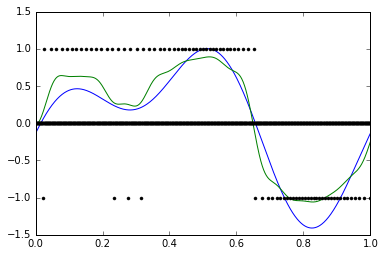

In [130]:
in_stim.output = WhiteSignal(T, high=2, rms=0.5)
sim = nengo.Simulator(model)
sim.run(T)
sig3 = sim.data[stim_p][:,0]

fspikes1_3 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2_3 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')
spikes_3 = (sim.data[spikes_p][:,0]-sim.data[spikes_p][:,1])*sim.dt

A3 = np.array([fspikes1_3, fspikes2_3]).T

d = sim.data[connection].weights.T

x3hat = np.dot(A3, d)[:,0]

t = sim.trange()
figure()
plot(t, sig3)
plot(t, x3hat)
plot(t, spikes_3, 'k.')
ylim(-1.5,1.5)
print 'RMSE:', np.average((sig3-x3hat)**2)

- The decoder works better if it is made for the right range of frequencies
- What does this tell us about rate vs timing codes?
     - Doesn't make much sense without thinking about the signal properties
     - These methods can account for both kinds of codes and smoothly vary between

## Optimal filters reconsidered

- So we have now found the optimal filter to apply to the spike data to decode out information
- Note a limitation: we've only done this for the case of 2 neurons!
    - But we could use the same filter for many more neurons
- Recall what this windowed filter looks like

(-0.2, 0.2)

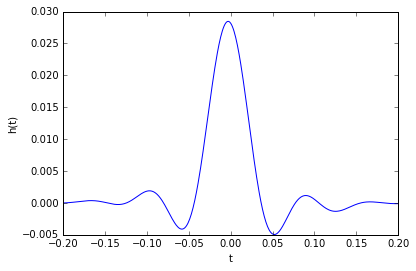

In [131]:
figure()
plot(t-T/2, h)
xlabel('t')
ylabel('h(t)')
xlim(-0.2, 0.2)

- What is this saying?
- Every time a spike occurs, when we interpret the data we should replace the spike with this shape
- What does this mean?


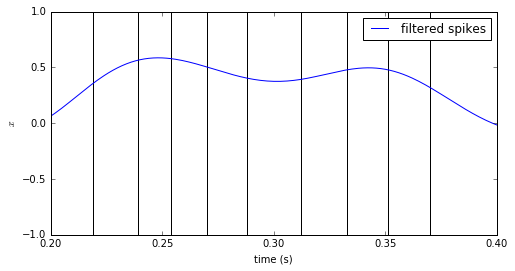

In [132]:
figure(figsize=(8,4))
vlines(dt*np.where(spikes1>0)[0], -1, 1)
plot(t, fspikes1_1*d[0], label='filtered spikes')
ylabel('$x$')
ylim(-1,1)
xlim(0.2, 0.4)
xlabel('time (s)')
legend();

- If we're analyzing the data after the fact, this is fine
- But what if we're just sitting here observing the neural activity and wanting to know what's being represented right now?
    - Notice that the blue line (the filtered value we're using for decoding) starts going up *before* the spike happens
    - The filtered value is using information *from the future*.
- This means that when we look at $\hat{x}$ this way, we're getting a better estimate of $x$ than it is possible for other neurons to get
    - (assuming neurons aren't psychic)
- What could we do instead?
    

## Biologically plausible filter

- We're looking for something that takes a spike and turns it into some smooth signal
- Instead of coming up with the optimal filter, is there anything from neuroscience we could use instead?
- What actually happens when a spike occurs?
    - What is the input to the next neuron that occurs when a spike happens?

<img src="files/lecture3/synapse.jpg">

- A spike causes a vesicle to release neurotransmitter
- The amount of neurotransmitter causes current to flow into the next neuron
- The neurotransmitter is slowly reabsorbed


- What is the current that goes into the next neuron thanks to a single spike?

<img src="files/lecture3/pscs.png">

(image stolen from [here](http://www.zoo.utoronto.ca/berry/zoo252/l9/lect9.htm))

- So other neurons don't get spikes as inputs
    - They get these post-synaptic currents
    
$$
h(t) = \begin{cases}
    e^{-t/\tau} &\mbox{if } t > 0 \\ 
    0 &\mbox{otherwise} 
    \end{cases}
$$

- This is the standard simple model
    - $\tau$ is different for different neurotransmitters and different neurotransmitter receptors
    - GABA-A-R: $\tau=10.41 \pm 6.16$ ms
    - AMPA-type GluR: $\tau=2.2 \pm 0.2$ ms
    - NMDA-type GluR: $\tau=146 \pm 9.1$ ms
    
- For more complex models, some people use     

$$
h(t) = \begin{cases}
    t^n e^{-t/\tau} &\mbox{if } t > 0 \\ 
    0 &\mbox{otherwise} 
    \end{cases}
$$


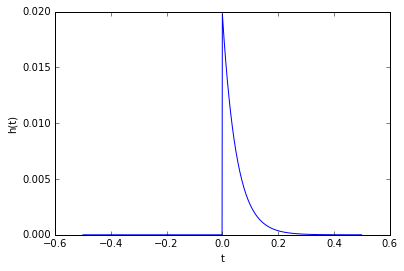

In [135]:
dt = 0.001
tau = 0.05
t_h = np.arange(1000)*dt-0.5
h = np.exp(-t_h/tau)
h[np.where(t_h<0)]=0
h = h/norm(h,1)

figure()
plot(t_h, h)
xlabel('t')
ylabel('h(t)');

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


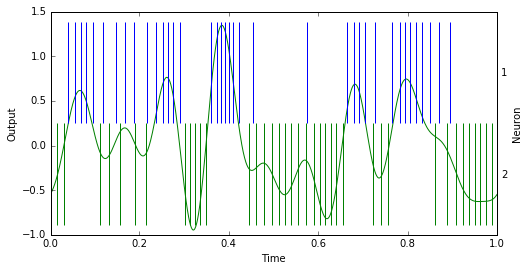

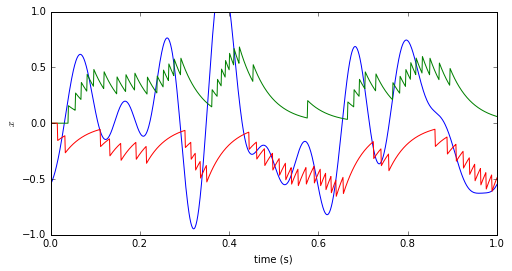

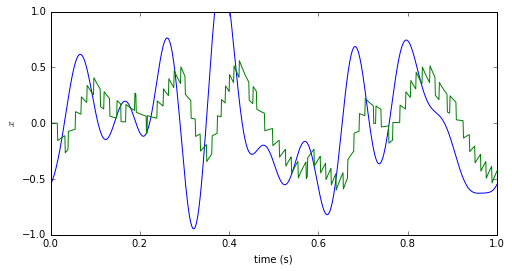

In [136]:
in_stim.output = WhiteSignal(T, high=10, rms=0.5)

sim = nengo.Simulator(model)
sim.run(T)
sig = sim.data[stim_p][:,0]

fspikes1 = np.convolve(sim.data[spikes_p][:,0], h, mode='same')
fspikes2 = np.convolve(sim.data[spikes_p][:,1], h, mode='same')

A = np.array([fspikes1, fspikes2]).T

d = sim.data[connection].weights.T

xhat = np.dot(A, d)

t = sim.trange()

from nengo.utils.matplotlib import rasterplot
figure(figsize=(8, 4))
ax = gca()
plot(t, sig,'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), use_eventplot=True, color='k')
ylabel("Neuron")

figure(figsize=(8,4))
plot(t, sig, label='x')
plot(t, fspikes1*d[0])
plot(t, fspikes2*d[1])
ylabel('$x$')
ylim(-1,1)
xlabel('time (s)')

figure(figsize=(8,4))
plot(t, sig, label='x')
plot(t, xhat, label='x')
ylabel('$x$')
ylim(-1,1)
xlabel('time (s)');

- What about with more neurons?

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


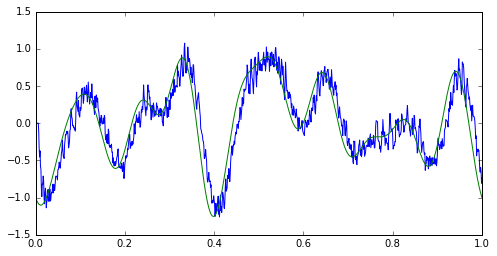

In [137]:
from nengo.dists import Uniform

with model:
    ens = nengo.Ensemble(40, dimensions=1, max_rates=Uniform(100,200))

    nengo.Connection(in_stim, ens)

    dec_p = nengo.Probe(ens, synapse = 0.005)
    
sim = nengo.Simulator(model)
sim.run(T)
sig = sim.data[stim_p][:,0]

t = sim.trange()
figure(figsize=(8,4))
plot(t,sim.data[dec_p])
plot(t,sig);

- What about different neurotransmitter time constants $\tau$? 

## A detail

- Notice that we find our decoders in two different ways
    - [Here](#decoders) we found them using activities directly
    - With Nengo, we just computed decoders using the non-spiking version of the neurons
    - Then run the model with spikes, filter the data with $h(t)$ and decode
    - You could filter all the spikes first and then invert the resulting A matrix

- Why does this work?
- Consider a single neuron with a constant $x$
    - When we found decoders using a rate mode, the firing rate was $a$
    - When we use spikes, we get $a(t)$, which is a sequence of $0$s and $1$s
    - If the rate neuron is a good model of the spiking neuron, then the firing rate (the sum of $a(t)$ divided by the total time) should approach $a$


- But what about $h(t)$?
    - It should just blur $a(t)$, pushing it towards this average
    - But this will only happen if $\int_{-\infty}^{\infty} h(t)dt=1$ 
    - Otherwise $h(t)$ will scale the value as well
- So this trick only works if we normalize $h(t)$
- It acts like an infinite amount of training with constant inputs
    - With more complex neuron models, there may be "memory" effects where the past history of the neuron doesn't end up averaging out like this
    - For those neuron models, there is no rate approximation anyway
    


- The filtered spiking neuron model gives some sort of variability around the ideal $a$ value
    - This can be treated as noise
    - We can find the variance of this noise (see Appendix C.1)
    - But we're already making sure decoders are robust to noise
    - So we don't have to do anything (except maybe slightly increase the amount of noise the decoders are supposed to be robust to)